# Dark Souls II Reviews (2025)

In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import altair as alt
from get_data import *

In [2]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('averaged_perceptron_tagger_eng')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\bdion\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\bdion\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\bdion\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\bdion\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     C:\Users\bdion\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping taggers\averaged_perceptron_tagger_eng.zip.


True

## Steam Reviews as of 3/26/25:

In [3]:
reviews = get_data()

In [4]:
reviews.shape

(45563, 10)

## EDA:

Distribution of whether or not people recommend buying the game:

In [5]:
recommended_props = reviews[['voted_up']].value_counts(normalize=True).reset_index()
recommended_props.rename(columns={0:'proportion'}, inplace=True)

props = alt.Chart(recommended_props).mark_bar().encode(
    alt.X('voted_up', sort=[True, False], axis=alt.Axis(labelAngle=0)).title('Recommeneded'),
    alt.Y('proportion').title('Proportion'),
    alt.Color('voted_up', legend=alt.Legend(title='Recommends game?', symbolSize=300), sort=[True, False]),
).properties(
    width=500,
    height=300,
    title="Proportion of people who recommend playing DS2:Scholar of the First Sin (2015-2024)",
).configure_legend(
    titleFontSize=12,
    labelFontSize=12,
) 
props

alt.Chart(...)

- Most people actually recommend the game

Proportions of those who don't and do recommend DS2 in each of the years:

In [6]:
yr_props = reviews.groupby(['year', 'voted_up'])[['review']].count().reset_index()
yr_props['total_reviews'] = yr_props.groupby('year')['review'].transform('sum')
yr_props['proportion'] = yr_props['review'] / yr_props['total_reviews']

yr_count_dist_line = alt.Chart(yr_props).mark_line().encode(
    alt.X('year:N', axis=alt.Axis(labelAngle=0)).title('Year'),
    alt.Y('review').title('Number of reviews'),
    alt.Color('voted_up', legend=alt.Legend(title='Recommends game?', symbolSize=300), sort=[True, False])
).properties(
    width=800,
    height=300,
    title="Count of Positive and Negative Reviews per Year (2015-2024)"
)

yr_count_dist_bar = alt.Chart(yr_props).mark_bar().encode(
    alt.X('year:N', axis=alt.Axis(labelAngle=0)).title('Year'),
    alt.Y('review').title('Number of reviews'),
    alt.Color('voted_up', legend=alt.Legend(title='Recommends game?', symbolSize=300), sort=[True, False])
).properties(
    width=800,
    height=300,
    title="Count of Positive and Negative Reviews per Year (2015-2024)"
)

(
    (yr_count_dist_line & yr_count_dist_bar)
)

alt.VConcatChart(...)

- Contrary to popular belief, most people actually recommend playing the since its release back in 2015
- Game released    : April 2015 (Scholar of the First Sin edition)
- Amount of reviews during pandemic (2020-2024) was the highest amount for the game ever (at least on Steam exclusively)

## Sentiment Analysis:
- Seeing why people were positive or negative about the game
    - Comments on story, gameplay, etc

Top 10 Most Common Words in the Reviews:

In [7]:
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

In [8]:
tfidf = TfidfVectorizer(sublinear_tf=True,
                        analyzer='word',
                        max_features=4000,
                        tokenizer=word_tokenize,
                        stop_words=stopwords.words("english"))

In [9]:
review_txt = reviews.review.values.flatten()
tfidf_array = tfidf.fit_transform(review_txt).toarray()
tfidf_df = pd.DataFrame(tfidf_array)
tfidf_df.columns = tfidf.get_feature_names_out()

c:\Users\bdion\anaconda3\Lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
c:\Users\bdion\anaconda3\Lib\site-packages\sklearn\feature_extraction\text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ["'d", "'ll", "'m", "'re", "'s", "'ve", 'could', 'might', 'must', "n't", 'need', 'sha', 'wo', 'would'] not in stop_words.
  warnings.warn(


In [10]:
most_unique = tfidf_df.idxmax(axis=1)
top_10 = most_unique.value_counts()[:10]
top_10

aaa      2533
good     1148
best      643
yes       416
die       302
great     283
bad       276
nice      266
fun       240
gud       236
dtype: int64

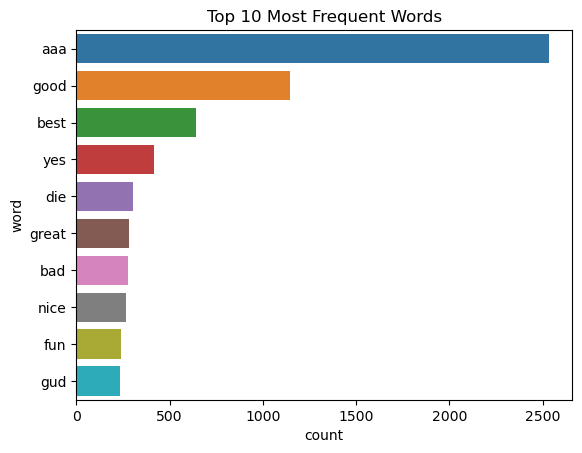

In [11]:
top_10 = top_10.reset_index()
top_10.rename(columns={'index':'word'}, inplace=True)
sns.barplot(data=top_10,
            y='word',
            x=0);
plt.title("Top 10 Most Frequent Words")
plt.xlabel("count")
plt.show()

- Most popular word w/ semantic meaning: Triple A 
    - def: an informal classification used to classify video games produced and distributed by a mid-sized or major publisher
- Top words used seem to be positive, but this is looking at the words without context

Other popular words:

In [12]:
from wordcloud import WordCloud

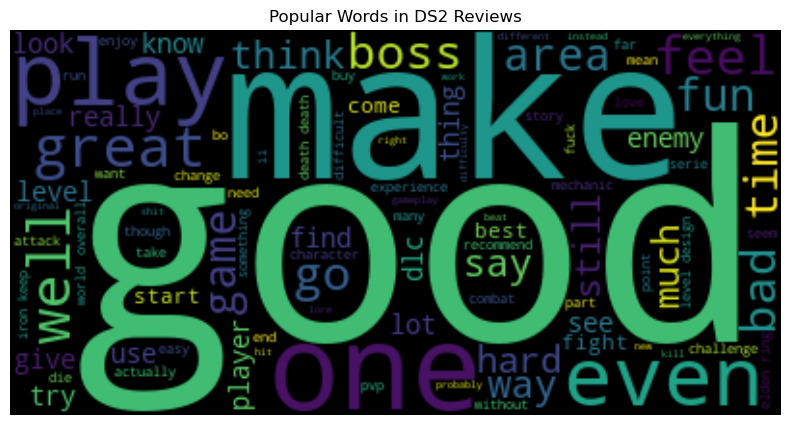

In [13]:
pop_wrds = " ".join( review for review in reviews.review)
wordcloud = WordCloud(max_font_size=150, max_words=100, background_color="black").generate(pop_wrds)
plt.figure(figsize=(20, 5))
plt.imshow(wordcloud, interpolation="bilinear") 
plt.axis("off")
plt.title('Popular Words in DS2 Reviews')
plt.show()

- Most common word among the reviews isn't very informative - including some of the other popular words
    - Looking at subsets of the reviews could be useful

### Topic Modeling:
- Exploring certain aspects on why people like the game
    - Also get critiques of the game in positive reviews (if any but there sure is considering DS2's reputation in the community)

- Exploring why people don't like the game:
    - Also get positive aspects within this subset of the reviews
    
- Algorithms I can use to perform topic modeling:
    1. Latent Dirichlet Allocation (LDA) 
    2. Non-negative Matrix Factorization (NMF)

Splitting the reviews by how many do and don't recommend buying the game:

In [14]:
pos_reviews = reviews[reviews['voted_up'] == True]
neg_reviews = reviews[reviews['voted_up'] == False]

In [15]:
pos_reviews.shape, neg_reviews.shape

((37387, 10), (8176, 10))

Function to display the output of the models:

In [16]:
def display_topics(model, feature_names, no_top_words):
    topic_dict = {}
    for topic_idx, topic in enumerate(model.components_):
        topic_dict["Topic %d words" % (topic_idx + 1)]= ['{}'.format(feature_names[i])
                        for i in topic.argsort()[:-no_top_words - 1:-1]]
        topic_dict["Topic %d weights" % (topic_idx + 1)]= ['{:.1f}'.format(topic[i])
                        for i in topic.argsort()[:-no_top_words - 1:-1]]
    return pd.DataFrame(topic_dict)

LDA: Probabilistic graphical modeling, and uses CountVectorizer as input

In [17]:
from sklearn.decomposition import LatentDirichletAllocation

In [18]:
count_vector = CountVectorizer()

tf = count_vector.fit_transform(reviews.review)
tf_feat_names = count_vector.get_feature_names_out()

pos_tf = count_vector.fit_transform(pos_reviews.review) 
pos_tf_feat_names = count_vector.get_feature_names_out()

neg_tf = count_vector.fit_transform(neg_reviews.review)
neg_tf_feat_names = count_vector.get_feature_names_out()

In [19]:
lda = LatentDirichletAllocation(n_components=3, random_state=42069)
lda.fit(tf)

LatentDirichletAllocation(n_components=3, random_state=42069)

In [20]:
no_top_words = 10
display_topics(lda, tf_feat_names, no_top_words)

,Topic 1 words,Topic 1 weights,Topic 2 words,Topic 2 weights,Topic 3 words,Topic 3 weights
0,play,5999.6,best,2993.4,good,12693.9
1,make,4345.2,love,2939.0,like,10330.4
2,get,3984.8,hate,2108.9,play,9065.8
3,like,3770.0,die,1978.9,bad,8392.4
4,one,3769.4,death,1732.8,get,8111.7
5,new,3289.6,keep,1631.9,time,6467.4
6,enemy,3140.9,iron,1377.5,enemy,6282.7
7,series,2947.8,fuck,1375.3,boss,6199.7
8,even,2862.3,play,1107.6,one,6161.5
9,well,2845.9,ever,1008.3,make,6069.4


- Interpreted topics that were identified:
    1. People saying how good the game is
    2. Bosses/enemies
    3. People expressing their likes or dislikes of the game

In [21]:
lda.fit(pos_tf)

LatentDirichletAllocation(n_components=3, random_state=42069)

In [22]:
display_topics(lda, pos_tf_feat_names, no_top_words)

,Topic 1 words,Topic 1 weights,Topic 2 words,Topic 2 weights,Topic 3 words,Topic 3 weights
0,play,8759.1,enemy,2513.9,good,3702.0
1,like,8286.4,ii,2391.9,die,2986.6
2,good,7692.4,new,2387.3,love,1932.4
3,one,6178.3,play,2345.4,get,1544.6
4,still,6059.4,death,2122.0,hate,1347.7
5,game,5915.3,make,1937.9,keep,1276.6
6,get,5644.3,player,1909.8,iron,1116.6
7,best,5433.3,get,1874.1,fuck,1093.6
8,bad,5336.1,yes,1764.0,kill,887.4
9,time,4447.6,version,1688.2,go,879.3


In [23]:
lda.fit(neg_tf)

LatentDirichletAllocation(n_components=3, random_state=42069)

In [24]:
display_topics(lda, neg_tf_feat_names, no_top_words)

,Topic 1 words,Topic 1 weights,Topic 2 words,Topic 2 weights,Topic 3 words,Topic 3 weights
0,play,779.6,bad,1886.5,enemy,4083.8
1,fuck,637.1,play,1544.9,like,3469.1
2,keep,624.0,trash,1093.5,make,3172.2
3,shit,605.9,good,796.9,get,2964.2
4,iron,560.8,one,595.9,play,2556.4
5,pc,533.1,like,584.8,time,2386.8
6,controller,484.3,game,573.8,boss,2187.1
7,control,444.1,make,364.8,one,2110.6
8,dont,414.4,want,356.9,feel,2014.0
9,buy,409.0,series,352.7,even,1965.9


- Interpreted topics that were identified:
    1. Bosses/enemies
    2. Controls/PC port of the game
    3. Players' comments on that it's the worst Dark Souls game they've played

NMF: Linear algebra and uses the TF-IDF vectorizer as input

In [25]:
from sklearn.decomposition import NMF

In [26]:
nmf = NMF(n_components=3, random_state=42069)
nmf.fit(tfidf_array)

NMF(n_components=3, random_state=42069)

In [27]:
display_topics(nmf, tfidf.get_feature_names_out(), no_top_words)

,Topic 1 words,Topic 1 weights,Topic 2 words,Topic 2 weights,Topic 3 words,Topic 3 weights
0,good,6.8,play,1.7,best,5.1
1,pretty,0.3,bad,1.6,ever,0.7
2,still,0.3,like,1.5,series,0.4
3,really,0.1,get,1.1,one,0.3
4,get,0.1,fun,1.1,game,0.2
5,elden,0.1,one,1.1,pvp,0.1
6,ring,0.1,great,1.0,still,0.1
7,actually,0.0,game,1.0,trilogy,0.1
8,yes,0.0,still,1.0,fight,0.1
9,bad,0.0,time,0.9,make,0.1


- Interpreted topics that were identified:
    1. 
    2. 
    3. 

In [28]:
pos_txt = pos_reviews.review.values.flatten()
pos_tfidf_array = tfidf.fit_transform(pos_txt).toarray()
nmf.fit(pos_tfidf_array)

c:\Users\bdion\anaconda3\Lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


NMF(n_components=3, random_state=42069)

In [29]:
display_topics(nmf, tfidf.get_feature_names_out(), no_top_words)

,Topic 1 words,Topic 1 weights,Topic 2 words,Topic 2 weights,Topic 3 words,Topic 3 weights
0,good,6.4,best,5.7,play,1.3
1,pretty,0.3,ever,0.7,like,1.1
2,still,0.2,series,0.4,great,1.1
3,bad,0.1,one,0.3,fun,1.0
4,really,0.1,game,0.2,bad,1.0
5,elden,0.1,pvp,0.2,still,0.9
6,get,0.1,trilogy,0.1,get,0.9
7,ring,0.0,still,0.1,one,0.8
8,actually,0.0,fight,0.1,game,0.8
9,hard,0.0,make,0.1,time,0.7


- Interpreted topics that were identified:
    1. Positive outloooks on the game
    2. similar to 1st topic
    3. People expressing their opinion on the game, ranging from good to bad

In [30]:
neg_txt = neg_reviews.review.values.flatten()
neg_tfidf_array = tfidf.fit_transform(neg_txt).toarray()
nmf.fit(neg_tfidf_array)

c:\Users\bdion\anaconda3\Lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


NMF(n_components=3, random_state=42069)

In [31]:
display_topics(nmf, tfidf.get_feature_names_out(), no_top_words)

,Topic 1 words,Topic 1 weights,Topic 2 words,Topic 2 weights,Topic 3 words,Topic 3 weights
0,play,1.1,bad,3.5,shit,2.2
1,like,0.9,ever,0.3,suck,1.9
2,good,0.8,play,0.1,fuck,1.2
3,make,0.7,one,0.1,trash,0.2
4,get,0.7,series,0.1,piece,0.2
5,enemy,0.7,game,0.1,buy,0.2
6,one,0.6,far,0.1,dog,0.2
7,time,0.6,really,0.1,still,0.1
8,game,0.6,terrible,0.1,play,0.1
9,feel,0.5,like,0.0,hate,0.1


- Interpreted topics that were identified:
    1. Vague but concerned w/ enemies
    2. Very negative perspectives on the game
    3. Negative experience regarding bosses, hitboxes, and game design